In [1]:
from Uncertainty import *
from uncertaintyMetric import *
from utils import *

from geneticalgorithm import geneticalgorithm as ga
import scipy.optimize as opt
from numdifftools import Jacobian, Hessian

K.clear_session()
check_tensorflow_gpu()

Checking Tensorflow Version:
Tensorflow built with CUDA? True
Tensorflow version: 2.6.2
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
def fopt(obj):
    res = proxy(ncol_data=int(obj[0]), measure_type=1,
                rom_obj=LinearRegression(), rom_data=LinearRegression(), 
                nMCSamples=750, nDataRealization=25, verbose=False)
    return res.value

In [2]:
def fopt(X):
    x, y = X 
    rosen = (1-x)**2 + 100*(y-x**2)**2
    f1 =  y*x**2 - 2*x*y**2 + 3*x*y + 4
    f2 = -x*y*np.exp(-(x**2+y**2)/2)
    f3 = 1 - ((1 + np.cos(12*np.sqrt(x**2+y**2)))/(0.5 * (x**2+y**2) + 2))
    f4 = np.abs(x*np.sin(x)+0.1*x) + np.abs(y*np.sin(y)*0.1*y)
    f5 = -20*np.exp(-0.2*np.sqrt(0.5*(x**2+y**2))) - np.exp(0.5*(np.cos (2*np.pi*x)+np.cos(2*np.pi*y))) + np.exp(1) + 20
    f6 = ((x**2+y**2)/4000) - np.cos(x)*np.cos(y/np.sqrt(2))+1
    f7 = x**2 + y**2 - 10*np.cos(2*np.pi*x) - 10*np.cos(2*np.pi*y) + 20
    f8 = (np.sqrt(np.sqrt(x**2+y**2)) + np.sqrt(np.sqrt(x**2+y**2))*np.sin(50*np.sqrt(x**2+y**2)**(1/5))**2)**2
    f9 = -x*np.sin(np.sqrt(np.abs(x))) - y*np.sin(np.sqrt(np.abs(y))) + 837.9657745448674
    f10 = (np.abs(x)+np.abs(y)) * np.exp(-np.sin(x**2) - np.sin(y**2))
    f11 = 1 - np.cos(2*np.pi*np.sqrt(x**2+y**2)) + 0.1*np.sqrt(x**2+y**2)
    #f12 = np.abs(x) + 2*y**(0.2)
    #f13 = x**2 + y**2 + (0.5*x+y)**2 + (0.5*x+y)**4
    #f14 = 10**4 * (1 + ((np.exp(-(x/15)**10 - (y/15)**10))-(-2*np.exp(-x**2-y**2)))*(np.cos(x)**2 * np.cos(y)**2)) 
    return f1

In [101]:
class FullOpt:
    def __init__(self, f):
        self.dims = 2
        self.fun = f
     
    def fun_jac(self, x):
        self.Jac = Jacobian(lambda x: self.fun(x))(x).ravel()
        return self.Jac
    
    def fun_hess(self, x):
        self.Hess = Hessian(lambda x: self.fun(x))(x)
        return self.Hess
        
    def global_opt(self, varbounds=np.array([[-3,3]]*2), vartype='real', 
                   maxiter=1000, maxiter_no_improv=100, pop_size=50, cross_prob=0.25, cross_type='uniform', 
                   mut_prob=0.2, parent_prop=0.2, elitratio=0.01, Convergence_Curve=False, Progress_Bar=False):
        
        params = {'max_num_iteration':              maxiter ,
                    'population_size':              pop_size,
                    'mutation_probability':         mut_prob,
                    'elit_ratio':                   elitratio,
                    'crossover_probability':        cross_prob,
                    'parents_portion':              parent_prop,
                    'crossover_type':               cross_type,
                    'max_iteration_without_improv': maxiter_no_improv}
        
        self.global_model = ga(function              = self.fun,
                                dimension            = self.dims,
                                variable_type        = vartype,
                                variable_boundaries  = varbounds,
                                algorithm_parameters = params,
                                convergence_curve    = Convergence_Curve,
                                progress_bar         = Progress_Bar)
        self.global_model.run()
        xsol, ysol, fsol = self.global_model.best_variable[0], self.global_model.best_variable[1], self.global_model.best_function
        self.global_res_df = pd.DataFrame(np.array((xsol, ysol, fsol)), index=['X','Y','f']).T
        return self.global_model, self.global_res_df
    
    def local_opt(self, x0=[-1,1], method='CG', options={}):
        '''
        Methods: ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 
                    'TNC', 'COBYLA', 'SLSQP', 'trust-constr', 'dogleg', 
                    'trust-ncg', 'trust-exact', 'trust-krylov']
        '''
        all_x, all_y, all_f = [x0[0]], [x0[1]], [self.fun(x0)]
        def store(X_):
            x, y = X_
            all_x.append(x)
            all_y.append(y)
            all_f.append(self.fun(X_))
        self.local_res = opt.minimize(fun=self.fun, x0=x0, method=method, jac=self.fun_jac, hess=self.fun_hess, callback=store, options=options)
        print('Method: {} | Solution: (x={:.3f}, y={:.3f}), f(x,y)={:.5f} | niter: {}'.format(method, all_x[-1], all_y[-1], all_f[-1], len(all_f)))
        self.local_res_df = pd.DataFrame({'X':all_x, 'Y':all_y, 'f':all_f})
        return self.local_res, self.local_res_df  
    
    def make_plot(self, global_res, local_res, labels=['GA','CG'], npts=500, levels=30, mbounds=[-3,3], 
                  angle=[30,45], alpha=0.8, msize=[60,60], markers=['d','*'], 
                  cmaps=['viridis','jet'], colors=['r','b'], figsize=(18,5)):
                
        xx = np.linspace(mbounds[0], mbounds[1], npts)
        X, Y = np.meshgrid(xx, xx)
        fig = plt.figure(figsize=figsize)
        
        ax1 = plt.subplot(121)
        im1 = plt.contourf(X, Y, self.fun([X,Y]), levels=levels, cmap=cmaps[0], alpha=alpha)
        ax1.scatter(global_res['X'], global_res['Y'], c=colors[0], s=msize[0], marker=markers[0], label=labels[0])
        ax1.plot(local_res['X'], local_res['Y'],  c=colors[1], linestyle='-', marker=markers[1], label=labels[1])
        plt.colorbar(im1); plt.xlabel('X'); plt.ylabel('Y'); plt.legend()
        
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.view_init(elev=angle[0], azim=angle[1])
        im2 = ax2.plot_surface(X, Y, self.fun([X,Y]), cmap=cmaps[1], alpha=alpha)
        ax2.scatter(global_res['X'], global_res['Y'], global_res['f'],                c=colors[0], marker=markers[0], s=msize[0], label=labels[0])
        ax2.scatter(local_res.iloc[-1,0], local_res.iloc[-1,1], local_res.iloc[-1,2], c=colors[1], marker=markers[1], s=msize[1], label=labels[1])
        plt.colorbar(im2); plt.xlabel('X'); plt.ylabel('Y'); plt.legend()
        plt.show()

In [102]:
local_res, local_res_df = FullOpt(fopt).local_opt(method='BFGS')

Method: BFGS | Solution: (x=-1.000, y=0.500), f(x,y)=3.50000 | niter: 10


c:\Users\381792\AppData\Local\anaconda3\envs\earth36\lib\site-packages\scipy\optimize\_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


In [103]:
global_res, global_res_df = FullOpt(fopt).global_opt()

 The best solution found:
 [ 2.99126183 -2.98965566]

 Objective function:
 -103.05095446332521


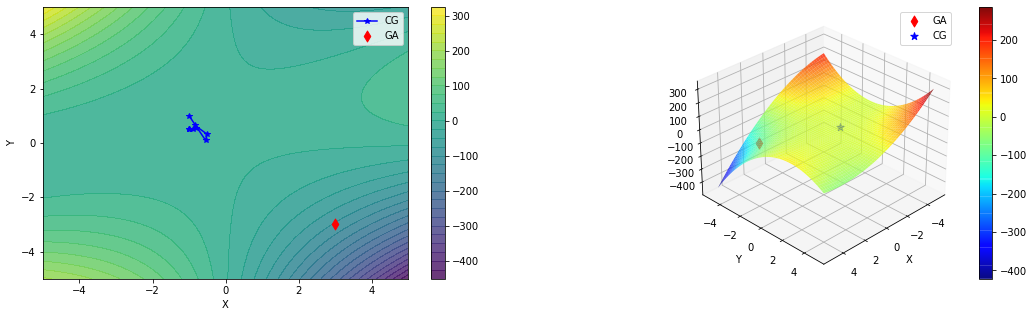

In [104]:
FullOpt(fopt).make_plot(global_res_df, local_res_df, mbounds=[-5,5])

***

In [ ]:
# General settings
Main_Directory   = os.getcwd()
Data_Directory   = os.path.join(Main_Directory, 'data')
titles           = ['.', 'Pressure', 'CO2 Saturation (l)', 'Temperature', 'Pressure + CO2 Saturation']
unc_params       = ['perm4', 'perm5', 'perm6', 'kmult']

MeasureType      = 1                           # Measurement type: 1 for pressure; 2 for CO2 saturation; 3 for tempeture, 4 for pressure+CO2 saturation                     
Total_time       = 1800                        # Total injection and post-injection time (days)
nTimeSeries      = 60                          # The number of measurement time series
nInterval        = 1                           # Measurement interval, default value = 1/Month

nTrain           = 500                         # The number of training simulations
Obj_filename     = 'run_co2mt.his'             # Objective file name
nColumn_obj      = 50                          # The column(s) in which the object of interest is located
nColumn_data     = [7]    #[7]                 # The column in which the data measurement is located 

x_max            = [1e-14, 1e-14, 1e-14, 2.0]  # Upper bounds for all the uncertain parameters
x_min            = [1e-19, 1e-19, 1e-19, 0.5]  # Lower bounds for all the uncertain parameters
ROMs_validation  = 0                           # ROMs cross-validation flag
nMCSamples       = 10000  #100000              # Number of monte carlo samples
nParam           = 4                           # Number of uncertain parameters
nDataRealization = 100    #200                 # Number of data realizations
err_option       = 3                           # Type of err option (2=MeanAE, 3=MaxAE)
time_sensitivity = 1                           # Whether consider time sensitivity for UR flag
post_processing  = 1                           # Plotting flag
print('Current Working Directory: {}'.format(Main_Directory))
print('Data Directory: {}'.format(Data_Directory))

## Step 1: Perfrom training simulation
# This step is done in a seperate code.

roms = [Ridge(), Ridge()]

In [ ]:
## Step 2: Read-in training simulation results
training_data, raw_data, parameters = read_train_sim_results(Data_Directory, MeasureType, Obj_filename, nColumn_obj, Total_time, nTimeSeries,
                                                                nColumn_data, nInterval, nTrain, nParam, x_min, x_max, titles)
#unpack variables
data_train, x_train, x_train_scaled, y_train, y_train_scaled = training_data
data_train_read_raw, data_train_read_raw0                    = raw_data
eps, nData, time_point                                       = parameters

plot_train_data(data_train, x_train_scaled, y_train_scaled, titles, MeasureType, Obj_filename, unc_params)

In [ ]:
## Step 3: 10-fold cross-validation of ROMs (iff ROMS_validation=1)
## Step 4: Construct the Mars ROMs for data and response of interest
ROM_data, ROM_obj = rom_validation(ROMs_validation, Ridge(), Ridge(), x_train_scaled, y_train, data_train, nTrain, nData, data_train_read_raw, NN=False)

In [ ]:
## Step 5: Generate Monte Carlo(MC) samples
np.random.seed(787878)
mc_design = np.random.rand(nMCSamples, nParam)
mc_design = mc_design*2 - 1
print('Generate Monte Carlo samples: Done!')

## Step 6: Evaluate the MC samples using the built ROMs for data points/objs
mc_data, mc_obj = evaluate_MC_with_ROM(ROM_data, ROM_obj, data_train_read_raw, mc_design, nData, nMCSamples)

In [ ]:
## Step 7: Calculate posterior distribution and uncertainty reduction
prior_mean, prior_p90mp10, synthetic_data, results = uncertainty_reduction(mc_obj, mc_data, ROM_data, data_train_read_raw, MeasureType,
                                                                            nData, nDataRealization, nParam, nColumn_data, 
                                                                            x_min, x_max, eps, err_option, time_sensitivity)

post_p90mp10_mean, post_p90mp10_time, post_p90mp10_iData, post_mean, post_mean_iData, nSamples, mc_obj_post = results

In [ ]:
## Step 8: Post-processing
make_post_processing(post_processing, results, synthetic_data, mc_obj, prior_p90mp10, data_train_read_raw0, time_point, Total_time, nDataRealization, nMCSamples, nColumn_data, nTimeSeries)

***
# END